/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM | 30 | RMSE = 3.128726


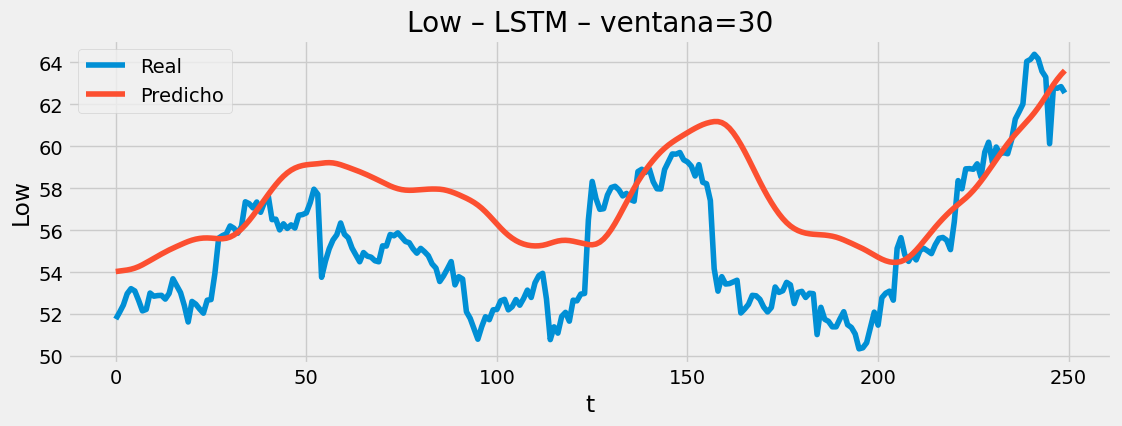

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM | 50 | RMSE = 2.327643


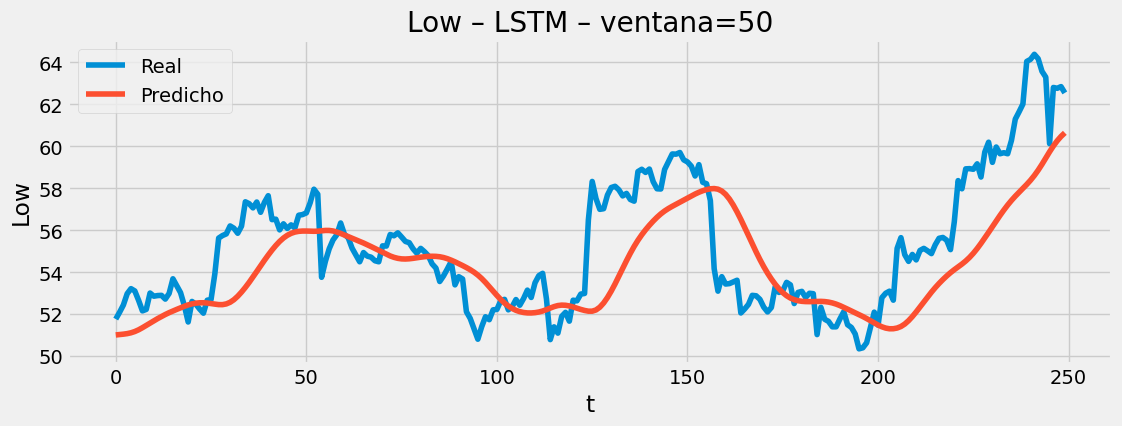

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


GRU  | 30 | RMSE = 3.148305


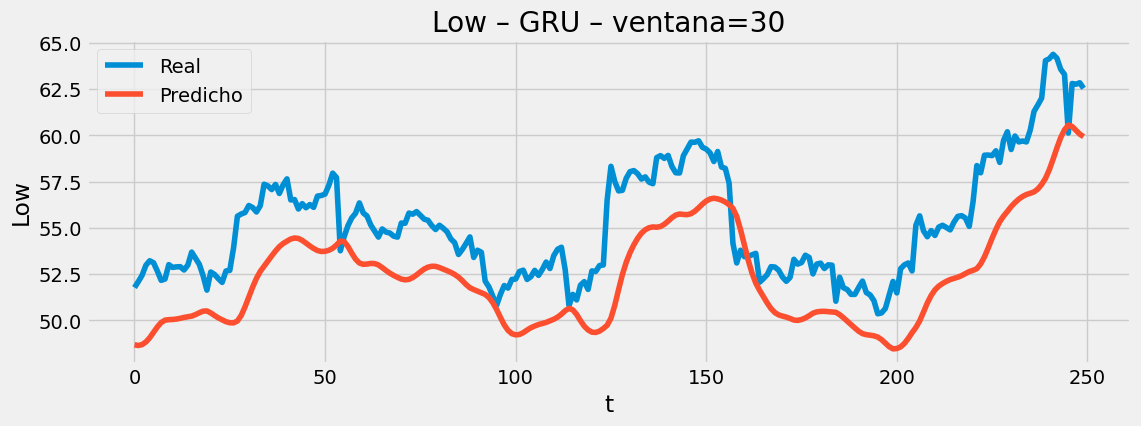

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


GRU  | 50 | RMSE = 1.450476


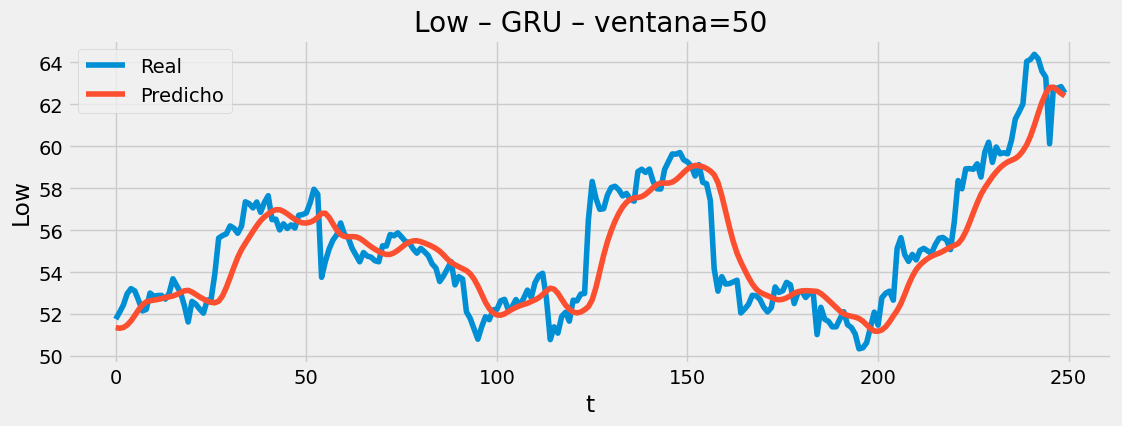

,Modelo,Ventana,RMSE
0,GRU,30,3.148305
1,GRU,50,1.450476
2,LSTM,30,3.128726
3,LSTM,50,2.327643


In [6]:
# ================================================================
# ===============  IMPLEMENTACIÓN RNN TIME SERIES  ===============
# ============  Predicción de 'Low' (NKE 2006–2018)  =============
# ================================================================

# ------------------------IMPORTS ---------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU

# ------------------- CONFIGURACIÓN BASE --------------------
np.random.seed(42); tf.random.set_seed(42)
PATH_FILE = 'NKE_2006-01-01_to_2018-01-01.csv'
TARGET = 'Low'
EPOCHS = 10
BATCH = 32

# ---------------------- CARGA DATOS ------------------------
df = pd.read_csv(PATH_FILE, index_col='Date', parse_dates=['Date']).dropna()
y_train = df.loc[:'2016', [TARGET]].values     # train ≤ 2016
y_test  = df.loc['2017':, [TARGET]].values     # test ≥ 2017

# Escalado SOLO con train
sc = MinMaxScaler((0,1))
y_train_s = sc.fit_transform(y_train)

# ------------------ HELPERS --------------------
def make_sequences(arr_scaled, win):
    X, y = [], []
    for i in range(win, len(arr_scaled)):
        X.append(arr_scaled[i-win:i, 0]); y.append(arr_scaled[i, 0])
    X = np.array(X).reshape(-1, win, 1); y = np.array(y)
    return X, y

def make_test_inputs(series, test, win, scaler):
    total = pd.concat((series[:'2016'], series['2017':]), axis=0)
    inp = total[len(total) - len(test) - win:].values.reshape(-1,1)
    inp = scaler.transform(inp)
    Xt = []
    for i in range(win, inp.shape[0]):
        Xt.append(inp[i-win:i, 0])
    return np.array(Xt).reshape(-1, win, 1)

def build_model(kind, timesteps):
    R = LSTM if kind == 'LSTM' else GRU
    m = Sequential()
    m.add(R(50, return_sequences=True, input_shape=(timesteps,1))); m.add(Dropout(0.2))
    m.add(R(50, return_sequences=True)); m.add(Dropout(0.2))
    m.add(R(50, return_sequences=True)); m.add(Dropout(0.2))
    m.add(R(50)); m.add(Dropout(0.2))
    m.add(Dense(1, activation='linear'))
    m.compile(optimizer='rmsprop', loss='mean_squared_error')
    return m

series_low = df[TARGET]
results = []

# ===================== LSTM (30 DÍAS) =======================
win = 30
X_tr, y_tr = make_sequences(y_train_s, win)
model_lstm30 = build_model('LSTM', win)
model_lstm30.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH, verbose=0)
X_te = make_test_inputs(series_low, y_test, win, sc)
pred_lstm30 = sc.inverse_transform(model_lstm30.predict(X_te, verbose=0))
rmse_lstm30 = math.sqrt(mean_squared_error(y_test, pred_lstm30))
print(f"LSTM | 30 | RMSE = {rmse_lstm30:.6f}")
plt.figure(figsize=(12,4)); plt.plot(y_test, label='Real'); plt.plot(pred_lstm30, label='Predicho')
plt.title(f"{TARGET} – LSTM – ventana=30"); plt.xlabel('t'); plt.ylabel(TARGET); plt.legend(); plt.show()
results.append(('LSTM', 30, float(rmse_lstm30)))

# ===================== LSTM (50 DÍAS) =======================
win = 50
X_tr, y_tr = make_sequences(y_train_s, win)
model_lstm50 = build_model('LSTM', win)
model_lstm50.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH, verbose=0)
X_te = make_test_inputs(series_low, y_test, win, sc)
pred_lstm50 = sc.inverse_transform(model_lstm50.predict(X_te, verbose=0))
rmse_lstm50 = math.sqrt(mean_squared_error(y_test, pred_lstm50))
print(f"LSTM | 50 | RMSE = {rmse_lstm50:.6f}")
plt.figure(figsize=(12,4)); plt.plot(y_test, label='Real'); plt.plot(pred_lstm50, label='Predicho')
plt.title(f"{TARGET} – LSTM – ventana=50"); plt.xlabel('t'); plt.ylabel(TARGET); plt.legend(); plt.show()
results.append(('LSTM', 50, float(rmse_lstm50)))

# ===================== GRU (30 DÍAS) =======================
win = 30
X_tr, y_tr = make_sequences(y_train_s, win)
model_gru30 = build_model('GRU', win)
model_gru30.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH, verbose=0)
X_te = make_test_inputs(series_low, y_test, win, sc)
pred_gru30 = sc.inverse_transform(model_gru30.predict(X_te, verbose=0))
rmse_gru30 = math.sqrt(mean_squared_error(y_test, pred_gru30))
print(f"GRU  | 30 | RMSE = {rmse_gru30:.6f}")
plt.figure(figsize=(12,4)); plt.plot(y_test, label='Real'); plt.plot(pred_gru30, label='Predicho')
plt.title(f"{TARGET} – GRU – ventana=30"); plt.xlabel('t'); plt.ylabel(TARGET); plt.legend(); plt.show()
results.append(('GRU', 30, float(rmse_gru30)))

# ====================== GRU (50 DÍAS) =======================
win = 50
X_tr, y_tr = make_sequences(y_train_s, win)
model_gru50 = build_model('GRU', win)
model_gru50.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH, verbose=0)
X_te = make_test_inputs(series_low, y_test, win, sc)
pred_gru50 = sc.inverse_transform(model_gru50.predict(X_te, verbose=0))
rmse_gru50 = math.sqrt(mean_squared_error(y_test, pred_gru50))
print(f"GRU  | 50 | RMSE = {rmse_gru50:.6f}")
plt.figure(figsize=(12,4)); plt.plot(y_test, label='Real'); plt.plot(pred_gru50, label='Predicho')
plt.title(f"{TARGET} – GRU – ventana=50"); plt.xlabel('t'); plt.ylabel(TARGET); plt.legend(); plt.show()
results.append(('GRU', 50, float(rmse_gru50)))

# ===================TABLA COMPARATIVA ======================
resumen = pd.DataFrame(results, columns=['Modelo','Ventana','RMSE']).sort_values(['Modelo','Ventana']).reset_index(drop=True)
display(resumen)
